# Deterministic slice flows

Consider a target density $\pi(x,u)=p(x)1_{[0,1]}(u)$ and let $F$ be the cdf of $p$.
Here the idea is to update a pair $(x,u)$ via
$$
\begin{pmatrix}x\\u\end{pmatrix}=
\begin{pmatrix}
    F^{-1}(\rho(u,x)+\xi\mod 1)\\ 
    \frac{1}{p(x')}((\rho(u,x)+\xi\mod 1)-F(x'-1))
\end{pmatrix},
$$
where $\rho(u,x)=F(x-1)+up(x)$ converts to proportions and $F(0)=0$ by convention.

We further think of this map as 
$$
\begin{pmatrix}x\\u\end{pmatrix}\mapsto
\begin{pmatrix}x\\p\end{pmatrix}\mapsto
\begin{pmatrix}x'\\u'\end{pmatrix},
$$
where the in between we switch the original uniform $u$ to $p=F^{-1}(\rho(u,x)+\xi\mod 1)$,
the proportion of the bin of $x$, and then set $u'=(p-F(x'-1))/p(x')$.

## The problem

We can't invert the flow reliably.
One potential reason for this is that 
there is error accumulation in the backward uniform variates $u$ that eventually causes an error.
Another potential explanation is that there is very little error in the backward $u'$
but when the values are close to a boundary in the $x$ probabilities then
that error is enough to output a different $x$, thereby disrupting the flow.

To test these hypotheses, we consider a univariate and a bivariate examples.
First we define all the necessary functions.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
# main functions
def update(x,u,prbs,xi=np.pi/16,direction='fwd'):
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[xp]
    if direction=='fwd': 
        outp=p
    else:
        outp=up*prbs[xp]+cdf(xp-1,prbs)
    return xp,up,outp


def getp(x,u,prbs,xi=np.pi/16):
    p=u*prbs[x]
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+xi)%1

def int_update(x,u,prbs,xi=np.pi/16,bigint=1e1,direction='fwd'):
    if direction=='bwd': xi=-xi 
    # integerize
    Mu=int(u*bigint)
    Mprbs=(prbs*bigint).astype(int)
        
    Mp=int_getp(x,Mu,Mprbs,xi,modulus=bigint)
    xp=quantile(Mp,Mprbs)
    Mup=M*(Mp-cdf(xp-1,Mprbs))/Mprbs[xp]
    return xp,Mup/M
    #return xp,up

def int_getp(x,u,prbs,xi=np.pi/16,modulus=1):
    p=int(u*prbs[x]/modulus)
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+int(modulus*xi))%modulus
    
# auxiliary functions
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)
def lcg_update(u,m,a=1.,c=0.): return (a*u+c)%m

## Univariate example

We generate a random univariate probability distribution.
Then we run our algorithm for 1,000 iterations and produce some diagnostic plots.
In this case we are actually able to invert the flow,
but the diagnostics plots are useful anyway.

In [3]:
# generate the distribution
np.random.seed(2022)
K=4
prbs=np.random.rand(K)
prbs=prbs/np.sum(prbs)
print('The probability distribution is '+str(prbs))

The probability distribution is [0.01393119 0.74289525 0.16878246 0.0743911 ]


Now we run the code and print the initial and final values.

In [4]:
# demo
n_iters=1000
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
u=np.zeros(n_iters+1)
u[0]=np.random.rand()
u[0]=0.10688645379435302 # trevor's example

# forward map
print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')')
for it in range(n_iters):
    tmpx,tmpu,_=update(x[it],u[it],prbs,xi)
    x[it+1]=tmpx
    u[it+1]=tmpu
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')')

Initial (u,x)=(0.10688645379435302,1)
Final (u,x)=(0.45376345437144106,2)


Running the flow backwards yields practically the same values,
with very little error:

In [5]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
bu[-1]=u[-1]
bx[-1]=x[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')')
for it in range(n_iters):
    tx,tu,_=update(bx[-(it+1)],bu[-(it+1)],prbs,xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
# end for
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')')

Final (u,x)=(0.45376345437144106,2)
Initial (u,x)=(0.10688645379438726,1)


### Error accumulation

We will show plots with two $y$-axes.
The left $y$-axis corresponds to the uniform variates
and the right $y$-axis to the $x$ variables.
This allows us to simultaneously track the uniform error accumulation
and whether it resulted in an error in the backwards flow of $x$.

We also denote by $u_b$ and $x_b$ the values of $u$ and $x$ (respectively)
in the backward flow, which in theory should be identical.

Note that the error accumulation is consistently in the order of $10^{-15}$,
and in turn this means that there are no errors inverting $x$.
Furthermore, note that there isn't a clear pattern in the error accumulation,
meaning that it is not actively increasing throughut the flow inversion.
This suggests that the error is not consistently accumulated,
a point against the first hypothesis.

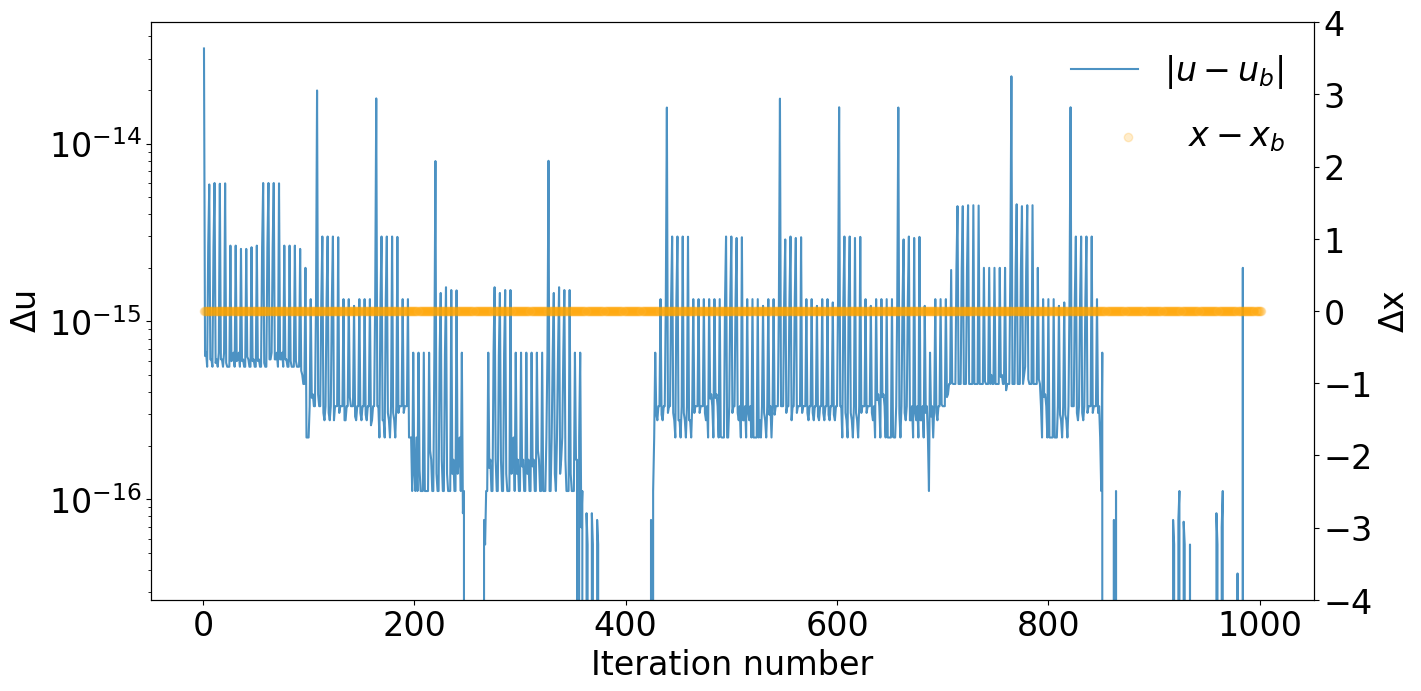

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1,n_iters+2),np.abs(u-bu),alpha=0.8,label=r'$|u-u_b|$')
ax2.scatter(np.arange(1,n_iters+2),x-bx, alpha=0.2,c='orange',label=r'$x-x_b$')

ax1.set_xlabel('Iteration number')
ax1.set_ylabel(r'$\Delta$u')
#ax1.set_ylim(-4e-14,4e-14)
ax1.set_yscale('log')
ax2.set_ylabel(r'$\Delta$x')
ax2.set_ylim(-prbs.shape[0],prbs.shape[0])

ax1.legend(frameon=False)
ax2.legend(loc=[0.8,0.75],frameon=False)
plt.show()

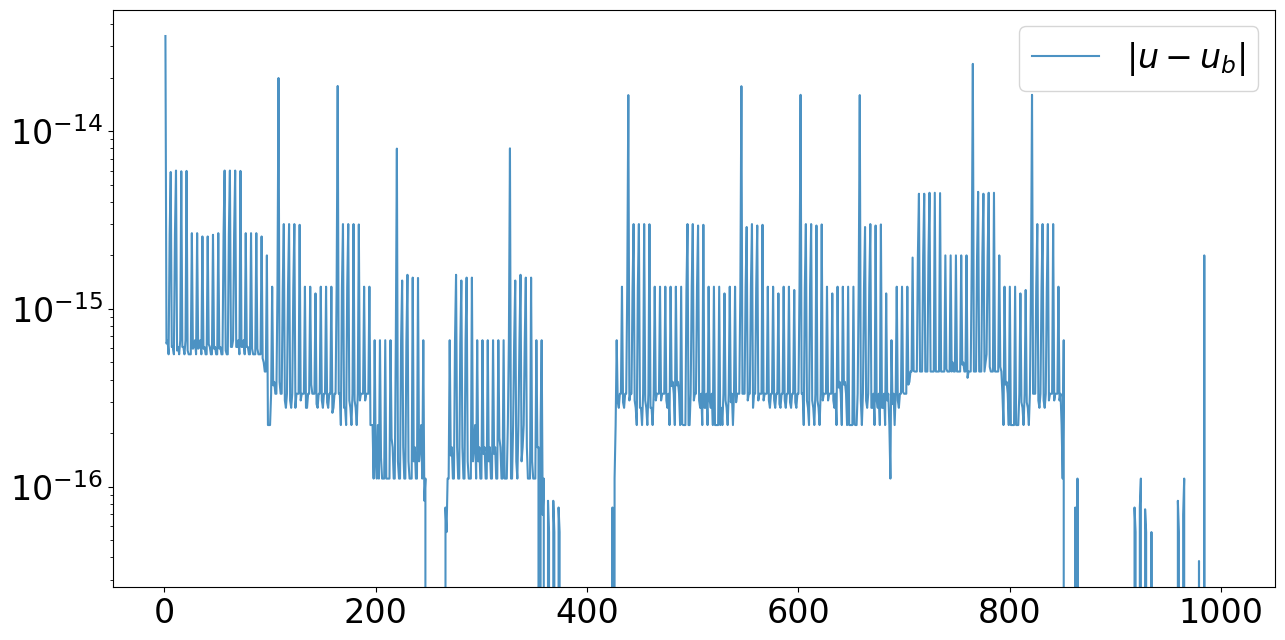

In [7]:
plt.plot(np.arange(1,n_iters+2),np.abs(u-bu),alpha=0.8,label=r'$|u-u_b|$')
plt.yscale('log')
plt.legend()

## Bivariate example

We will now consider a random bivariate example.

### Uniform distribution
First I'll show that not all bivariate examples cause issues.
Indeed, if we choose the uniform distribution,
we are able to correctly run and invert the flow after 10,000 iterations.

In [8]:
np.random.seed(2022)
prbs=np.ones((4,4)) # uniform
prbs=prbs/np.sum(prbs)
print('The probability distribution is '+str(prbs))

The probability distribution is [[0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]]


In [9]:
# demo
np.random.seed(2022)
n_iters=200
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
y=np.zeros(n_iters+1,dtype=int)+2
u=np.zeros(n_iters+1)
v=np.zeros(n_iters+1)
pu=np.zeros(n_iters+1)
pv=np.zeros(n_iters+1)
u[0]=np.random.rand()
v[0]=np.random.rand()

print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')   (v,y)=('+str(v[0])+','+str(y[0]+1)+')')

# forward map
for it in range(n_iters):
    # step in (x,u)
    xprbs=prbs[:,y[it]]/np.sum(prbs[:,y[it]])
    tmpx,tmpu,tmppu=update(x[it],u[it],xprbs)
    x[it+1]=tmpx
    u[it+1]=tmpu
    pu[it+1]=tmppu
    # step in (y,v)
    yprbs=prbs[x[it+1],:]/np.sum(prbs[x[it+1],:])
    tmpy,tmpv,tmppv=update(y[it],v[it],yprbs)
    y[it+1]=tmpy
    v[it+1]=tmpv
    pv[it+1]=tmppv
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')   (v,y)=('+str(v[-1])+','+str(y[-1]+1)+')')

Initial (u,x)=(0.009358613807764704,1)   (v,y)=(0.49905781085198797,3)
Final (u,x)=(0.08899129329742017,2)   (v,y)=(0.5786904903416437,4)


In [10]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
bpu=np.zeros(n_iters+2)
by=np.zeros(n_iters+1,dtype=int)
bv=np.zeros(n_iters+1)
bpv=np.zeros(n_iters+2)
bu[-1]=u[-1]
bpu[-1]=pu[-1]
bx[-1]=x[-1]
bv[-1]=v[-1]
bpv[-1]=pv[-1]
by[-1]=y[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')  (v,y)=('+str(bv[-1])+','+str(by[-1]+1)+')')
for it in range(n_iters):
    tx=bx[-(it+1)]
    ty,tv,tpu=update(by[-(it+1)],bv[-(it+1)],prbs[tx,:]/np.sum(prbs[tx,:]),xi,'bwd')
    by[-(it+2)]=ty
    bv[-(it+2)]=tv
    bpu[-it+1]=tpu
    tx,tu,tpv=update(bx[-(it+1)],bu[-(it+1)],prbs[:,ty]/np.sum(prbs[:,ty]),xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
    bpv[-(it+1)]=tpv
# end for
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')  (v,y)=('+str(bv[0])+','+str(by[0]+1)+')')

Final (u,x)=(0.08899129329742017,2)  (v,y)=(0.5786904903416437,4)
Initial (u,x)=(0.009358613807764371,1)  (v,y)=(0.49905781085198786,3)


I won't show the error accumulation plot since there is virtually none.

This exercise tells us that whatever failure is happening is sensitive to the target distribution.

### Troublesome example

Now we consider a random example 
(which thanks to the random seed I can reproduce)
where some probabilities are closer to others when compared to the uniform case.

We show the probability distribution and run the flow for 200 iterations&mdash;no more
are needed to have an error in the inversion of the flow.

In [11]:
np.random.seed(2022)
prbs=np.random.rand(4,4)
prbs=prbs/np.sum(prbs)
print('The probability distribution is '+str(prbs))

The probability distribution is [[0.00100416 0.0535481  0.01216589 0.00536213]
 [0.07354313 0.05225303 0.09631717 0.06947056]
 [0.0962427  0.07737661 0.08920288 0.08879672]
 [0.08944174 0.10268931 0.03949057 0.05309528]]


In [12]:
# demo
np.random.seed(2022)
n_iters=200
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
y=np.zeros(n_iters+1,dtype=int)+2
u=np.zeros(n_iters+1)
v=np.zeros(n_iters+1)
pu=np.zeros(n_iters+1)
pv=np.zeros(n_iters+1)
u[0]=np.random.rand()
v[0]=np.random.rand()

print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')   (v,y)=('+str(v[0])+','+str(y[0]+1)+')')

# forward map
for it in range(n_iters):
    # step in (x,u)
    xprbs=prbs[:,y[it]]/np.sum(prbs[:,y[it]])
    tmpx,tmpu,tmppu=update(x[it],u[it],xprbs)
    x[it+1]=tmpx
    u[it+1]=tmpu
    pu[it+1]=tmppu
    # step in (y,v)
    yprbs=prbs[x[it+1],:]/np.sum(prbs[x[it+1],:])
    tmpy,tmpv,tmppv=update(y[it],v[it],yprbs)
    y[it+1]=tmpy
    v[it+1]=tmpv
    pv[it+1]=tmppv
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')   (v,y)=('+str(v[-1])+','+str(y[-1]+1)+')')

Initial (u,x)=(0.009358613807764704,1)   (v,y)=(0.49905781085198797,3)
Final (u,x)=(0.12408289392805444,2)   (v,y)=(0.8520575926581329,3)


When inverting the flow,
I will printout the true value of $(u,x)$ and the inverted values $(u_b,x_b)$,
along with the differences $|u-u_b|$ and $|x-x_b|$.

In [13]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
bpu=np.zeros(n_iters+2)
by=np.zeros(n_iters+1,dtype=int)
bv=np.zeros(n_iters+1)
bpv=np.zeros(n_iters+2)
bu[-1]=u[-1]
bpu[-1]=pu[-1]
bx[-1]=x[-1]
bv[-1]=v[-1]
bpv[-1]=pv[-1]
by[-1]=y[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')  (v,y)=('+str(bv[-1])+','+str(by[-1]+1)+')')
print()
print('Iter |          (u,x)          |           (u_b,x_b)      |            |u-u_b|       |    |x-x_b|')
for it in range(n_iters):
    tx=bx[-(it+1)]
    ty,tv,tpu=update(by[-(it+1)],bv[-(it+1)],prbs[tx,:]/np.sum(prbs[tx,:]),xi,'bwd')
    by[-(it+2)]=ty
    bv[-(it+2)]=tv
    bpu[-it+1]=tpu
    tx,tu,tpv=update(bx[-(it+1)],bu[-(it+1)],prbs[:,ty]/np.sum(prbs[:,ty]),xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
    bpv[-(it+1)]=tpv
    
    print(str(n_iters-it)+'  |  ('+str(u[-min(it+2,n_iters)])+','\
          +str(x[-(it+2)])+') | ('+str(tu)+','+str(tx)+') |   '+\
          str(np.abs(u[-min(it+2,n_iters)]-tu))+' |      '+str(np.abs(x[-(it+2)]-tx)))
# end for
print()
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')  (v,y)=('+str(bv[0])+','+str(by[0]+1)+')')

Final (u,x)=(0.12408289392805444,2)  (v,y)=(0.8520575926581329,3)

Iter |          (u,x)          |           (u_b,x_b)      |            |u-u_b|       |    |x-x_b|
200  |  (0.43145169171075176,3) | (0.4314516917107517,3) |   5.551115123125783e-17 |      0
199  |  (0.8471839573949226,2) | (0.8471839573949225,2) |   1.1102230246251565e-16 |      0
198  |  (0.31627217322178364,2) | (0.3162721732217838,2) |   1.6653345369377348e-16 |      0
197  |  (0.7191104718847188,1) | (0.719110471884719,1) |   2.220446049250313e-16 |      0
196  |  (0.10656622032580651,1) | (0.10656622032580691,1) |   4.0245584642661925e-16 |      0
195  |  (0.3887286749732569,3) | (0.38872867497325847,3) |   1.5543122344752192e-15 |      0
194  |  (0.7904846913943024,2) | (0.7904846913943047,2) |   2.220446049250313e-15 |      0
193  |  (0.25957290722116366,2) | (0.2595729072211657,2) |   2.0539125955565396e-15 |      0
192  |  (0.6449106072800145,1) | (0.6449106072800173,1) |   2.7755575615628914e-15 |      0
191  

### Diagnostics

Note that the error in $u$ slowly increases over the flow until mistakes in $x$ start happening.
Below we visualize the error in $u$ and the error in $x$ across iterations.
The plot should be visualized from right to left since we are inverting the flow.

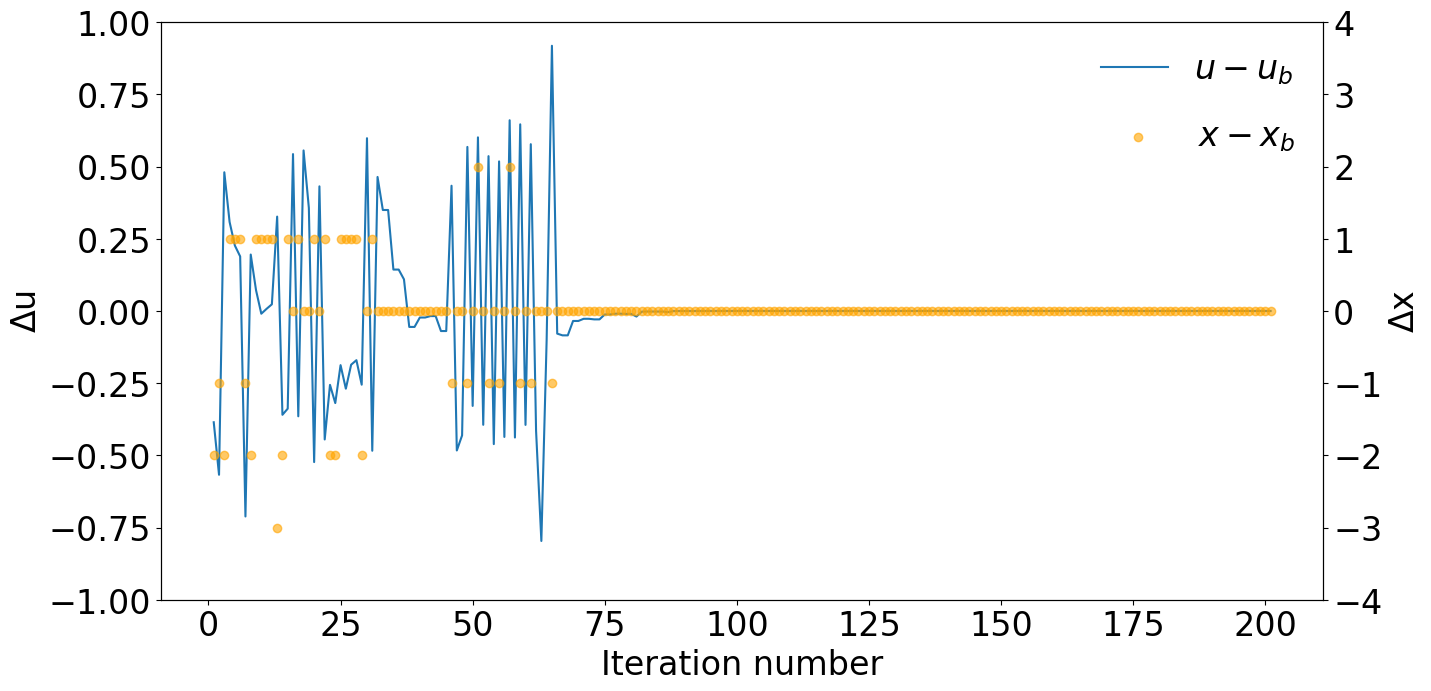

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax2.plot(np.arange(1,n_iters+2),x, alpha=0.8,c='green')
#ax2.plot(np.arange(1,n_iters+2),bx, alpha=0.8,c='orange')
ax2.scatter(np.arange(1,n_iters+2),x-bx, alpha=0.6,c='orange',label=r'$x-x_b$')
ax1.plot(np.arange(1,n_iters+2),u-bu,alpha=1,label=r'$u-u_b$')

ax1.set_xlabel('Iteration number')
ax1.set_ylabel(r'$\Delta$u')
ax1.set_ylim(-1,1)
ax2.set_ylabel(r'$\Delta$x')
ax2.set_ylim(-prbs.shape[0],prbs.shape[0])

ax1.legend(frameon=False)
ax2.legend(loc=[0.8,0.75],frameon=False)
plt.show()

It's clear that there are errors past the 75 iteration mark,
at which point the difference in $u$'s bounces quickly and results
in errors with $x$ inversion.

But a look at the absolute difference in $u$'s in log scale reveals that the error does accumulate over time
until reaching a no-return point.

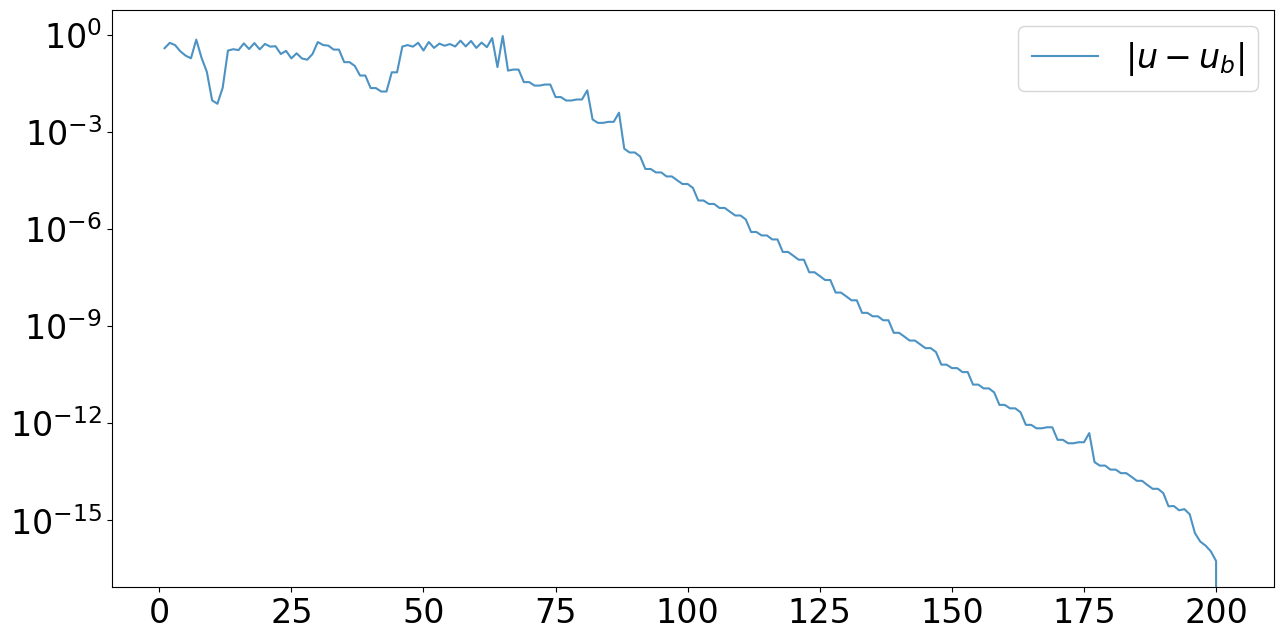

In [15]:
plt.plot(np.arange(1,n_iters+2),np.abs(u-bu),alpha=0.8,label=r'$|u-u_b|$')
plt.yscale('log')
plt.legend()

This suggests that,
when there are inversion errors,
there is an accumulation in uniform error and it's not because of a boundary in $x$-values probabilities.

### Misc plots

work in progress, move along, move along.

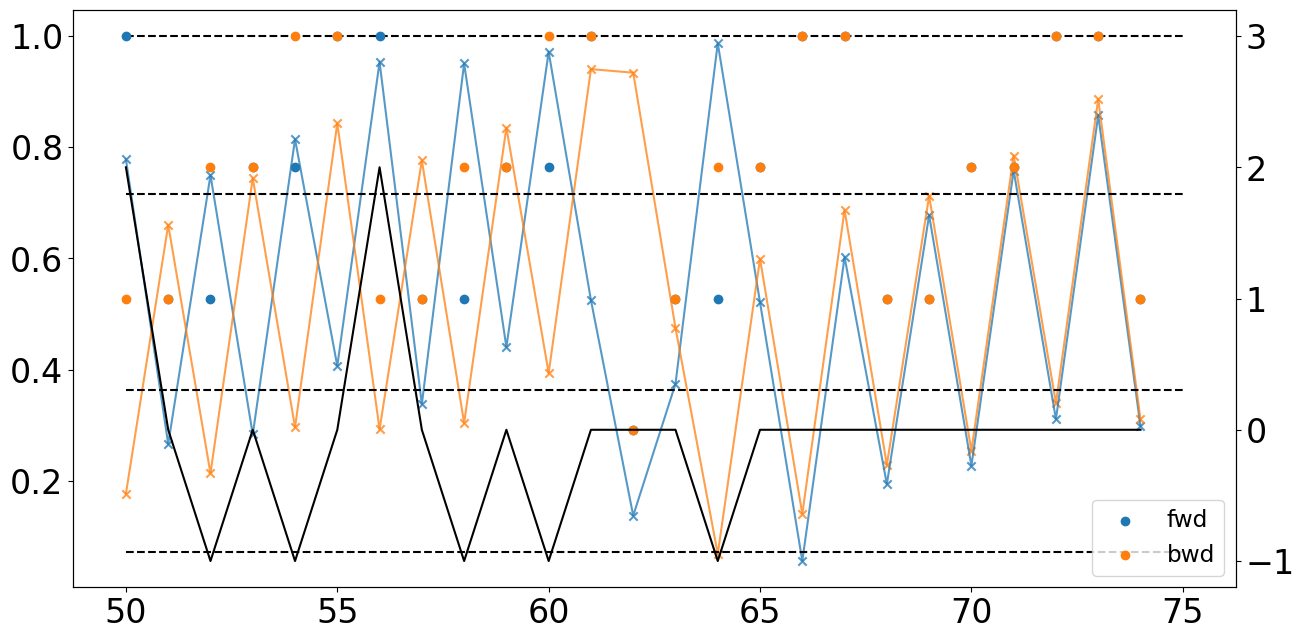

In [16]:
xprbs=np.sum(prbs,axis=1)

colors=['#3F4788','#238A8D','#DCE318','#DD5E66']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
it0,itf=50,75
ax1.plot(np.arange(it0,itf),u[it0:itf],alpha=0.75, label='fwd')
ax1.scatter(np.arange(it0,itf),u[it0:itf],alpha=0.75, label='fwd', marker='x')
ax1.plot(np.arange(it0,itf),bu[it0:itf],alpha=0.75, label='bwd')
ax1.scatter(np.arange(it0,itf),bu[it0:itf],alpha=0.75, label='bwd', marker='x')
ax2.scatter(np.arange(it0,itf),x[it0:itf], alpha=1, label='fwd')
ax2.scatter(np.arange(it0,itf),bx[it0:itf], alpha=1, label='bwd')
ax2.plot(np.arange(it0,itf),x[it0:itf]-bx[it0:itf], alpha=1, label='', c='black')
for n in range(prbs.shape[0]): ax1.hlines(np.cumsum(xprbs)[n],it0,itf,colors='black', label='P(X='+str(n)+')',ls='dashed')
plt.legend(fontsize='x-small')

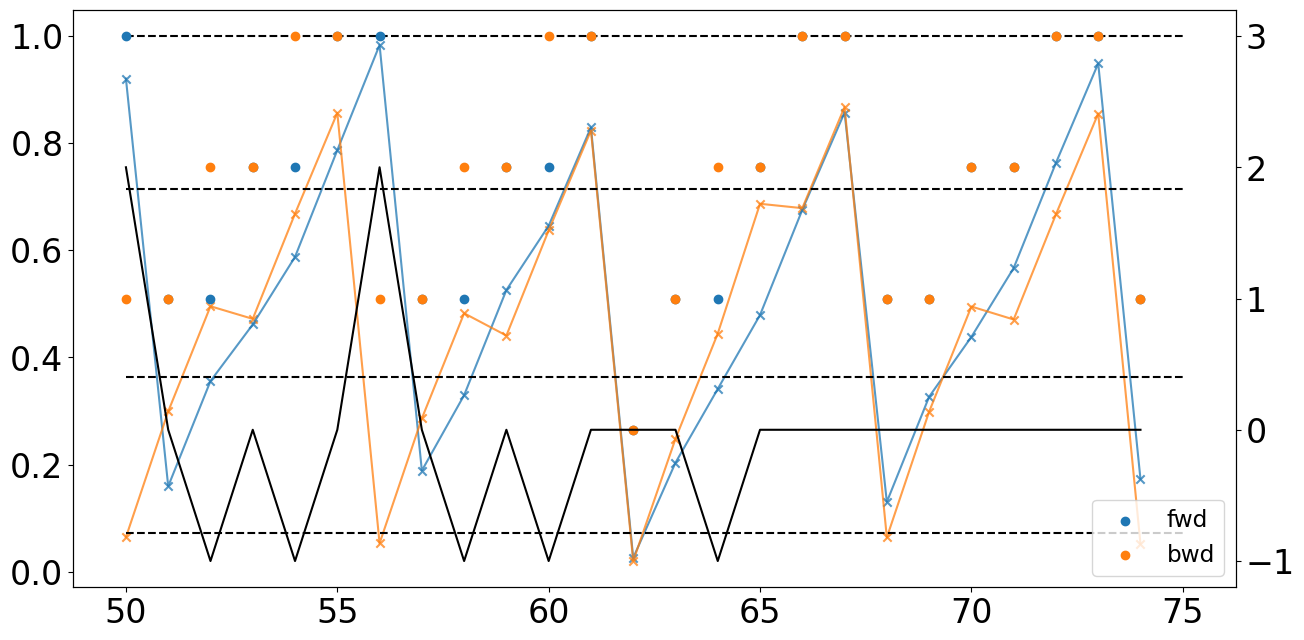

In [17]:
xprbs=np.sum(prbs,axis=1)

colors=['#3F4788','#238A8D','#DCE318','#DD5E66']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
it0,itf=50,75
ax1.plot(np.arange(it0,itf),pu[it0:itf],alpha=0.75, label='fwd')
ax1.scatter(np.arange(it0,itf),pu[it0:itf],alpha=0.75, label='fwd', marker='x')
ax1.plot(np.arange(it0,itf),bpu[it0:itf],alpha=0.75, label='bwd')
ax1.scatter(np.arange(it0,itf),bpu[it0:itf],alpha=0.75, label='bwd', marker='x')
ax2.scatter(np.arange(it0,itf),x[it0:itf], alpha=1, label='fwd')
ax2.scatter(np.arange(it0,itf),bx[it0:itf], alpha=1, label='bwd')
ax2.plot(np.arange(it0,itf),x[it0:itf]-bx[it0:itf], alpha=1, label='', c='black')
for n in range(prbs.shape[0]): ax1.hlines(np.cumsum(xprbs)[n],it0,itf,colors='black', label='P(X='+str(n)+')',ls='dashed')
plt.legend(fontsize='x-small')